<a href="https://colab.research.google.com/github/SarangMohrir/Angular/blob/main/Anamoly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection
Anomaly detection is the problem of identifying data points that don't conform to expected (normal) behaviour. Unexpected data points are also known as outliers and exceptions etc. Anomaly detection has crucial significance in the wide variety of domains as it provides critical and actionable information. For example, an anomaly in MRI image scan could be an indication of the malignant tumour or anomalous reading from production plant sensor may indicate faulty component.

Here we implement anomaly detection algorithm (in Python) to detect outliers in computer servers.
To keep things simple we will use two features:
1) throughput in mb/s and
2) latency in ms of response for each server.

The Gaussian model will be used to learn an underlying pattern of the dataset with the hope that our features follow the gaussian distribution. After that, we will find data points with very low probabilities of being normal and hence can be considered outliers. For training set, we will first learn the gaussian distribution of each feature for which mean and variance of features are required. Numpy provides the method to calculate both mean and variance (covariance matrix) efficiently. Similarly, Scipy library provide method to estimate gaussian distribution.

We first importing requried libraries and defining functions for reading data, mean normalizing features and estimating gaussian distribution.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

In [2]:
def read_dataset(filePath,delimiter=','):
    return genfromtxt(filePath, delimiter=delimiter)

def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

We later define a function to find the optimal value for threshold (epsilon) that can be used to differentiate between normal and anomalous data points. For learning the optimal value of epsilon we will try different values in a range of learned probabilities on a cross-validation set. The f-score will be calculated for predicted anomalies based on the ground truth data available. The epsilon value with highest f-score will be selected as threshold i.e. the probabilities that lie below the selected threshold will be considered anomalous.

In [3]:
def selectThresholdByCV(probs,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs),max(probs),stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon)
        f = f1_score(gt, predictions, average = "binary")
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
    return best_f1, best_epsilon

We now call above defined functions to find anomalies in the dataset. Also, as we are dealing with only two features here, plotting helps us visualize the anomalous data points.

Number of datapoints in training set: 307
Number of dimensions/features: 2
[[13.409 13.763]
 [14.196 15.853]
 [14.915 16.174]
 [13.577 14.043]]


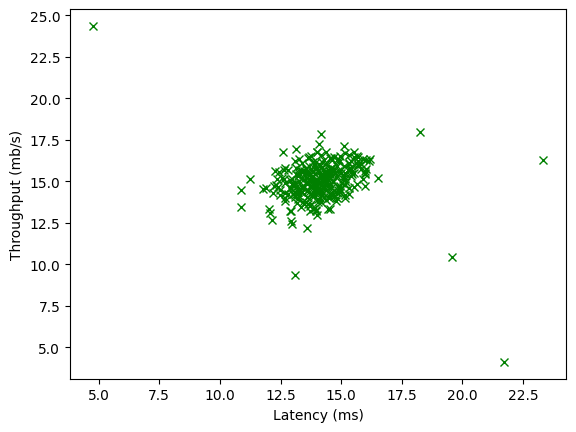

In [4]:
tr_data = read_dataset('tr_server_data.csv')
cv_data = read_dataset('cv_server_data.csv')
gt_data = read_dataset('gt_server_data.csv')

n_training_samples = tr_data.shape[0]
n_dim = tr_data.shape[1]

print('Number of datapoints in training set: %d' % n_training_samples)
print('Number of dimensions/features: %d' % n_dim)


print(tr_data[1:5,:])

plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.plot(tr_data[:,0],tr_data[:,1],'gx')
plt.show()

fscore: 0.8750000000000001 EP: 9.036201327981216e-05


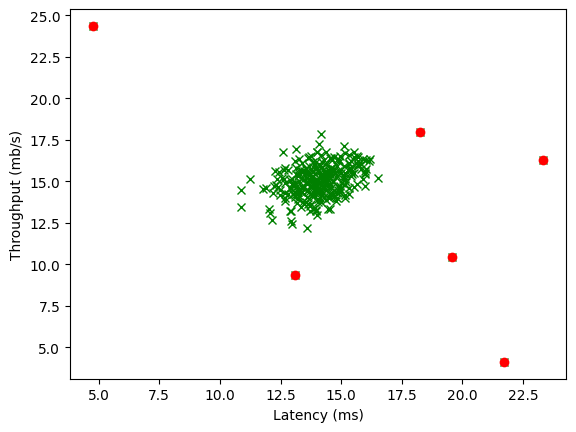

In [5]:
mu, sigma = estimateGaussian(tr_data)
p = multivariateGaussian(tr_data,mu,sigma)

#selecting optimal value of epsilon using cross validation
p_cv = multivariateGaussian(cv_data,mu,sigma)
fscore, ep = selectThresholdByCV(p_cv,gt_data)
print("fscore:",fscore,"EP:", ep)

#selecting outlier datapoints
outliers = np.asarray(np.where(p < ep))

plt.figure()
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.plot(tr_data[:,0],tr_data[:,1],"gx")
plt.plot(tr_data[outliers,0],tr_data[outliers,1],"ro")
plt.show()

We implemented a very simple anomaly detection algorithm.
References:
    Chandola, Varun, Arindam Banerjee, and Vipin Kumar. "Anomaly detection: A survey." ACM computing surveys (CSUR) 41.3 (2009): 15.